In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 

In [3]:
file_path = 'data_input_auto/中国10年期国债收益率.xlsx'
excel_data = pd.ExcelFile(file_path)
sheet = excel_data.parse('Sheet1')
sheet.rename(columns={'DataTime': 'Date'}, inplace=True)

fill_methods = {
    '二手房出售挂牌价指数同比': 'interpolate',    
    '新增社融(预测/3年季节性/12MMA)同比': 'interpolate'
} 
sheet = fill_missing_values(sheet, fill_methods, return_only_filled=False)

In [4]:
last_day = sheet['Date'][sheet['中国10年期国债收益率/彭博'].last_valid_index()]

In [5]:
# 生成完整的工作日日期范围
start_date = sheet['Date'].min()
end_date = sheet['Date'].max()
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')

# 创建新的DataFrame,包含所有工作日
weekday_df = pd.DataFrame(index=all_weekdays)
weekday_df.index.name = 'Date'

# 将原始数据与工作日日期对齐
sheet_aligned = sheet.set_index('Date')
weekday_df = weekday_df.join(sheet_aligned)

# 重置索引,使Date成为列
sheet = weekday_df.reset_index()

In [6]:
fill_methods = {
    '二手房出售挂牌价指数同比': 'interpolate',    
    '新增社融(预测/3年季节性/12MMA)同比': 'interpolate'
} 
sheet = fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet['二手房出售挂牌价指数同比_提前70天'] = sheet['二手房出售挂牌价指数同比'].shift(70)
sheet['新增社融(预测/3年季节性/12MMA)同比_提前90天'] = sheet['新增社融(预测/3年季节性/12MMA)同比'].shift(90)

In [7]:
sheet

,Date,中国10年期国债收益率/彭博,二手房出售挂牌价指数同比,新增社融(预测/3年季节性/12MMA)同比,二手房出售挂牌价指数同比_提前70天,新增社融(预测/3年季节性/12MMA)同比_提前90天
0,2003-01-31,NaN,NaN,-5.232200,NaN,NaN
1,2003-02-03,NaN,NaN,-6.144450,NaN,NaN
2,2003-02-04,NaN,NaN,-7.056700,NaN,NaN
3,2003-02-05,NaN,NaN,-7.968950,NaN,NaN
4,2003-02-06,NaN,NaN,-8.881200,NaN,NaN
...,...,...,...,...,...,...
5974,2025-12-25,NaN,-0.098,0.236470,-0.098,0.154314
5975,2025-12-26,NaN,-0.098,0.236702,-0.098,0.155935
5976,2025-12-29,NaN,-0.098,0.236935,-0.098,0.157556
5977,2025-12-30,NaN,-0.098,0.237167,-0.098,0.159177


In [8]:
sheet = sheet[sheet['Date'] >= '2015-01-01']
sheet_daily = sheet[sheet['Date'] <= last_day+ pd.Timedelta(days=60)]
sheet_daily = sheet_daily[(sheet_daily['Date'] > last_day) | sheet_daily['中国10年期国债收益率/彭博'].notna()]
sheet_daily

,Date,中国10年期国债收益率/彭博,二手房出售挂牌价指数同比,新增社融(预测/3年季节性/12MMA)同比,二手房出售挂牌价指数同比_提前70天,新增社融(预测/3年季节性/12MMA)同比_提前90天
3111,2015-01-05,3.65,NaN,-0.054671,NaN,-0.094825
3112,2015-01-06,3.64,NaN,-0.057143,NaN,-0.095050
3113,2015-01-07,3.65,NaN,-0.059614,NaN,-0.095275
3116,2015-01-12,3.65,NaN,-0.062086,NaN,-0.095838
3119,2015-01-15,3.56,NaN,-0.064557,NaN,-0.096287
...,...,...,...,...,...,...
5782,2025-04-01,NaN,-0.098,0.037645,-0.104433,-0.100954
5783,2025-04-02,NaN,-0.098,0.039491,-0.104100,-0.101565
5784,2025-04-03,NaN,-0.098,0.041336,-0.103767,-0.102177
5785,2025-04-04,NaN,-0.098,0.043182,-0.103433,-0.102788


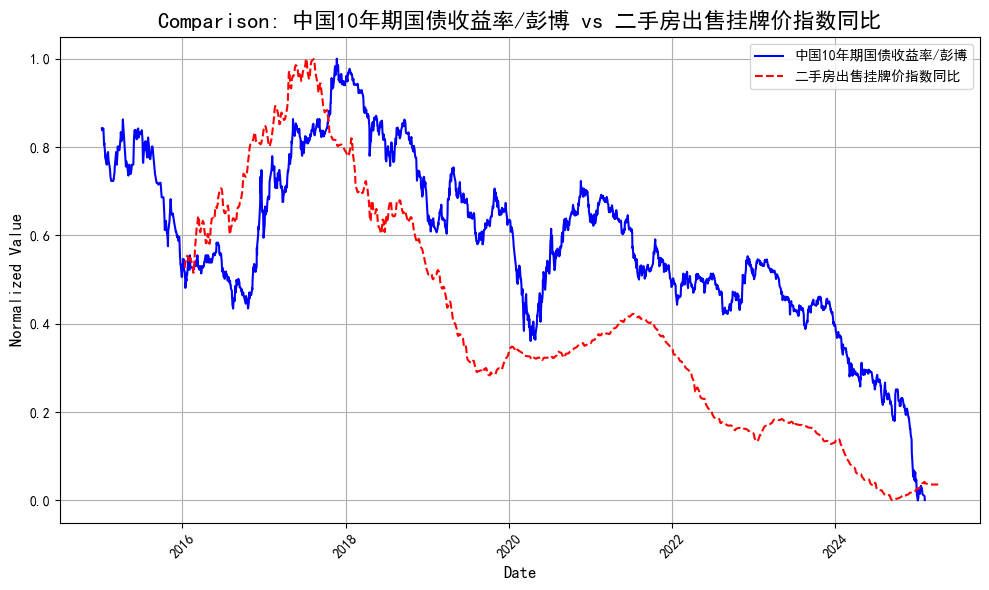

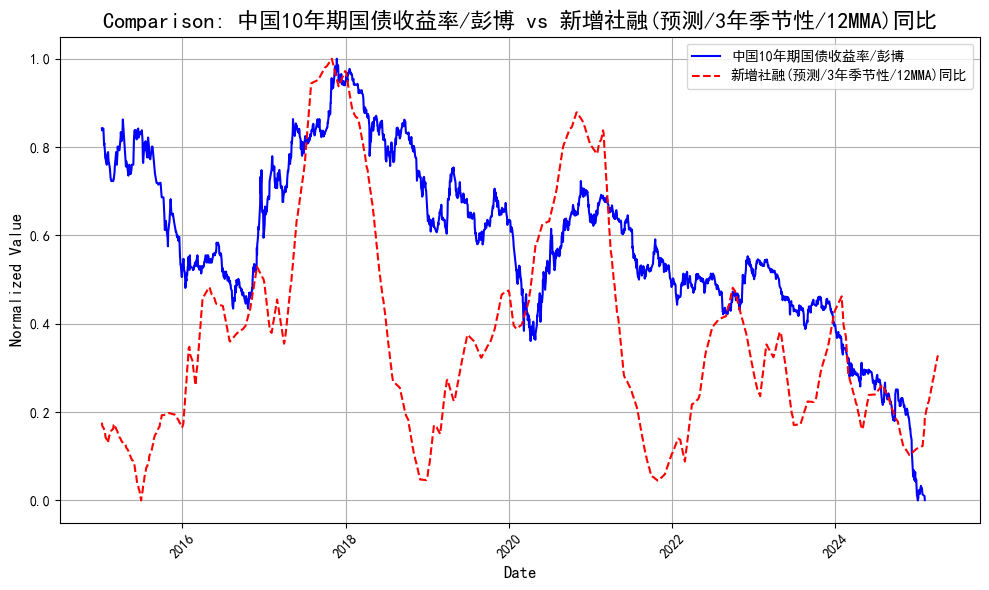

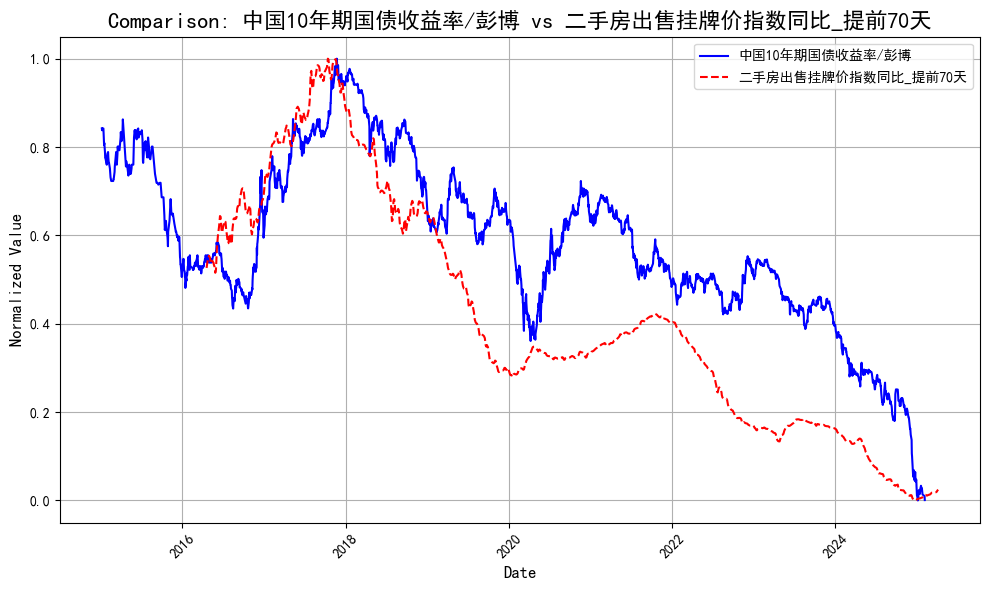

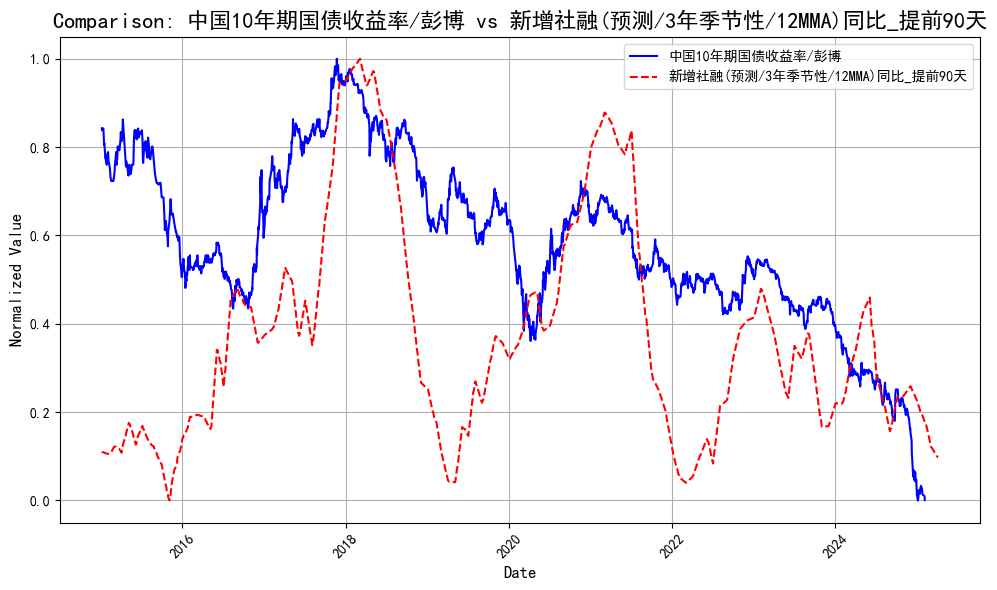

In [9]:
sheet_daily_plot = sheet_daily.set_index('Date')

plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='中国10年期国债收益率/彭博', 
    compare_cols=['二手房出售挂牌价指数同比','新增社融(预测/3年季节性/12MMA)同比','二手房出售挂牌价指数同比_提前70天','新增社融(预测/3年季节性/12MMA)同比_提前90天']
)

---

In [10]:
# 划分训练集、测试集和未来数据
train_data = sheet_daily[sheet_daily['Date'] <= last_day]
test_period = 100
test_data = train_data[-test_period:]  
train_data = train_data[:-test_period]  
future_data = sheet_daily[sheet_daily['Date'] > last_day]

# 准备训练、测试和未来数据的输入和输出
X_train = train_data[['二手房出售挂牌价指数同比_提前70天', '新增社融(预测/3年季节性/12MMA)同比_提前90天']]
y_train = train_data['中国10年期国债收益率/彭博']
X_test = test_data[['二手房出售挂牌价指数同比_提前70天', '新增社融(预测/3年季节性/12MMA)同比_提前90天']]
y_test = test_data['中国10年期国债收益率/彭博']

X_future = future_data[['二手房出售挂牌价指数同比_提前70天', '新增社融(预测/3年季节性/12MMA)同比_提前90天']]

In [11]:
# 初始化 MinMaxScaler
scaler = MinMaxScaler()

# 归一化特征数据
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

# 定义并训练 XGBRegressor 模型
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.08, max_depth=3, subsample=0.9, colsample_bytree=0.8)
xgb.fit(X_train_scaled, y_train)


# 训练集和测试集的预测
y_train_pred = xgb.predict(X_train_scaled)
y_test_pred = xgb.predict(X_test_scaled)

# 计算 MSE 和 R^2 分数
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse}, Train R^2: {train_r2}")
print(f"Test MSE: {test_mse}, Test R^2: {test_r2}")

# 未来预测


X_all = sheet_daily[sheet_daily['Date'] <= last_day][['二手房出售挂牌价指数同比_提前70天', '新增社融(预测/3年季节性/12MMA)同比_提前90天']]
y_all = sheet_daily[sheet_daily['Date'] <= last_day]['中国10年期国债收益率/彭博']

# 归一化所有历史特征数据
X_all_scaled = scaler.fit_transform(X_all)

# 使用所有历史数据重新训练模型
xgb.fit(X_all_scaled, y_all)


y_future_pred = xgb.predict(X_future_scaled)

test_data = test_data.copy()
future_data = future_data.copy()

test_data.loc[:, '预测值'] = y_test_pred
future_data.loc[:, '预测值'] = y_future_pred

Train MSE: 0.02124216178714241, Train R^2: 0.873600320204013
Test MSE: 0.12696601317005704, Test R^2: -1.9687234883857037


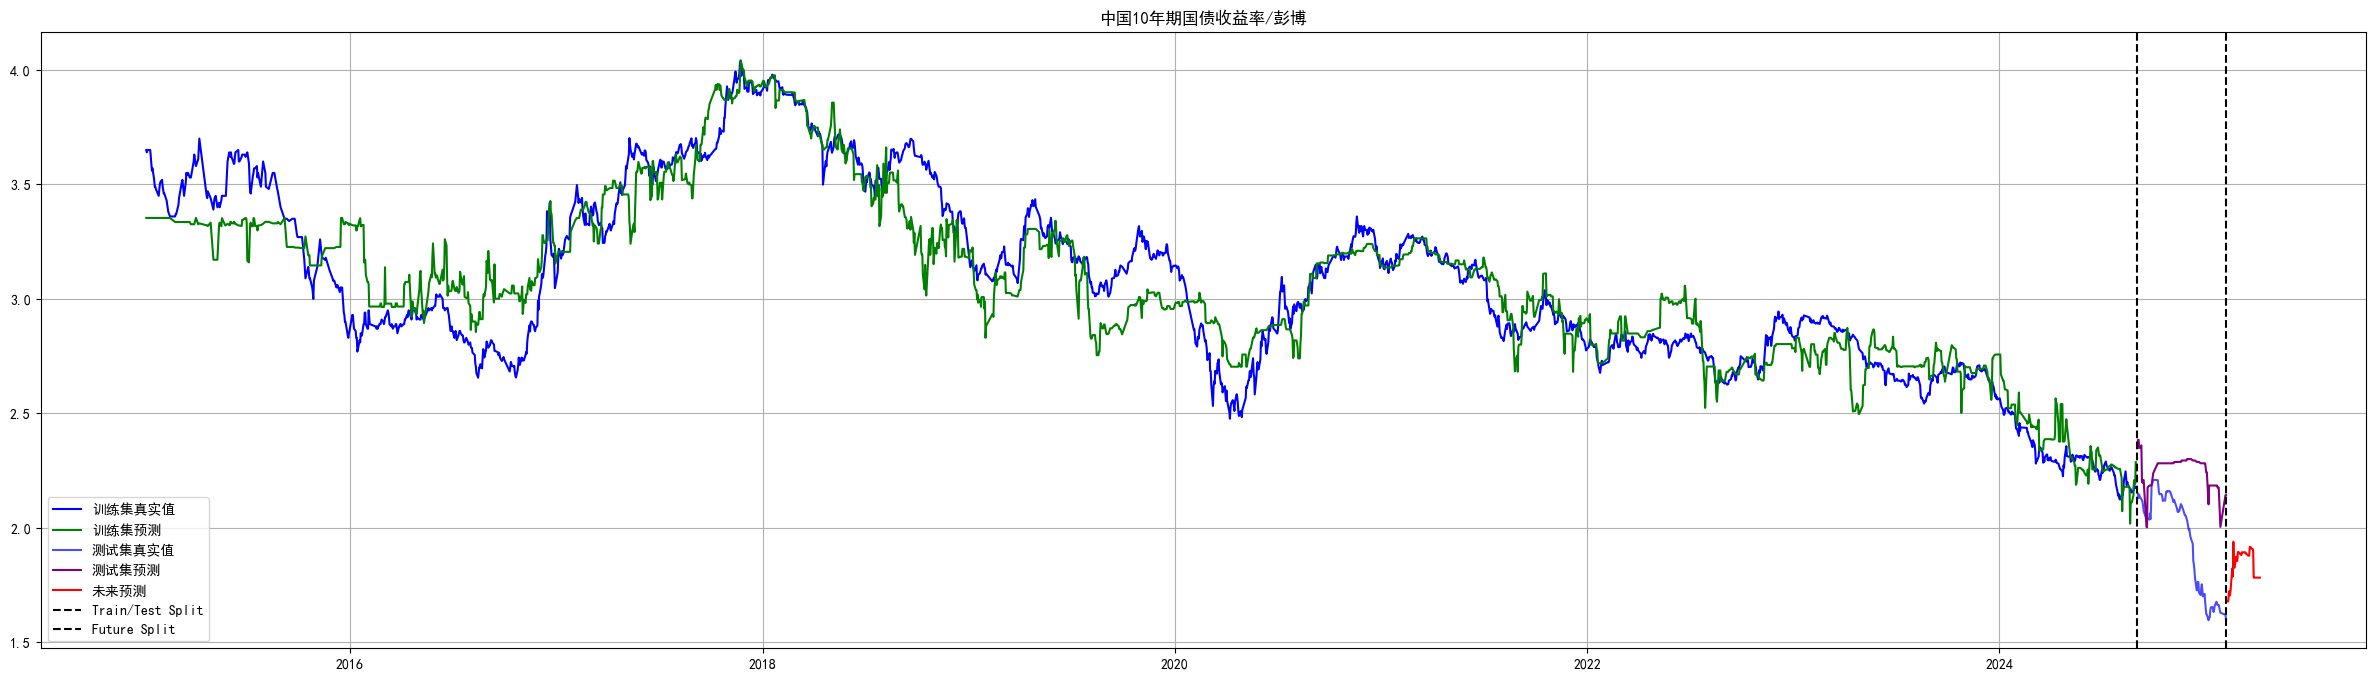

In [12]:
# 可视化
plt.figure(figsize=(30, 8))

plt.plot(train_data['Date'], y_train, label='训练集真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集真实值', color='blue',alpha=0.7)
plt.plot(test_data['Date'], test_data['预测值'], label='测试集预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')

plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('中国10年期国债收益率/彭博')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# 创建一个包含2018年之后数据的DataFrame
train_pred_df = pd.DataFrame({
    'Date': train_data['Date'],
    '预测值': y_train_pred
})
train_pred_df = train_pred_df[train_pred_df['Date'].dt.year >= 2018]

test_pred_df = pd.DataFrame({
    'Date': test_data['Date'],
    '预测值': test_data['预测值']
})

future_pred_df = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值']
})

# 合并所有预测数据
all_predictions = pd.concat([train_pred_df, test_pred_df, future_pred_df])
all_predictions = all_predictions.rename(columns={'预测值': '中国10年期国债收益率预测值'})

all_predictions.to_excel('data_output_auto/中国10年期国债收益率预测结果_2018年后.xlsx', index=False)

---

In [15]:
# 任务1: 合并训练集、测试集真实值和未来预测
# 获取2023年以后的训练集数据
train_data_2023 = train_data[train_data['Date'].dt.year >= 2023][['Date', '中国10年期国债收益率/彭博']]
test_actual = test_data[['Date', '中国10年期国债收益率/彭博']]

# 合并训练集和测试集的真实值
historical_actual = pd.concat([train_data_2023, test_actual])
historical_actual.columns = ['Date', '实际值']

# 获取未来预测值
future_pred = future_data[['Date', '预测值']]  # 修改这里的列名
future_pred.columns = ['Date', '预测值']

# 合并所有数据
merged_df = pd.merge(historical_actual, future_pred, on='Date', how='outer')
merged_df = merged_df.sort_values('Date', ascending=False)

# 将日期格式转换为年/月/日格式
merged_df['Date'] = merged_df['Date'].dt.strftime('%Y/%m/%d')

# 保存到Excel
merged_df.to_excel('eta/中国10年期国债收益率_合并数据.xlsx', index=False,float_format='%.2f')
merged_df

,Date,实际值,预测值
545,2025/04/07,NaN,1.783181
544,2025/04/04,NaN,1.783181
543,2025/04/03,NaN,1.783181
542,2025/04/02,NaN,1.783181
541,2025/04/01,NaN,1.783181
...,...,...,...
4,2023/01/09,2.842,NaN
3,2023/01/06,2.835,NaN
2,2023/01/05,2.837,NaN
1,2023/01/04,2.818,NaN


In [16]:
# 任务2: 生成月度数据
# 获取2023年以后的实际值
actual_values = pd.concat([
    train_data[train_data['Date'].dt.year >= 2023][['Date', '中国10年期国债收益率/彭博']],
    test_data[['Date', '中国10年期国债收益率/彭博']]
])
actual_values.columns = ['Date', '实际值']

# 创建包含2024年及以后训练集预测值的DataFrame
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred[train_data['Date'].dt.year >= 2024]
})

# 重新构建predictions DataFrame
predictions = pd.concat([
    train_pred_2024,
    test_data[['Date', '预测值']],
    future_data[['Date', '预测值']]
], ignore_index=True)

# 重新合并实际值和预测值
monthly_df = pd.merge(actual_values, predictions, on='Date', how='outer')

# 转换为月度数据
monthly_df['Date'] = pd.to_datetime(monthly_df['Date'])
monthly_df.set_index('Date', inplace=True)
monthly_df = monthly_df.resample('ME').mean()
monthly_df.reset_index(inplace=True)
monthly_df = monthly_df.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
monthly_df['Date'] = monthly_df['Date'].dt.strftime('%Y/%m/%d')
# 保存月度数据
monthly_df.to_excel('eta/中国10年期国债收益率_月度数据.xlsx', index=False,float_format='%.2f')
monthly_df.head()

,Date,实际值,预测值
27,2025/04/30,NaN,1.783181
26,2025/03/31,NaN,1.878238
25,2025/02/28,1.610000,1.839526
24,2025/01/31,1.642111,2.175517
23,2024/12/31,1.809864,2.290694
